In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np


import os
print(os.listdir("../input/newhandwriting/generated/"))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['1', '8', '0', '3', '2', '6', '9', '5', '4', '7']


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function = preprocessing,
        validation_split = 0.1,
    )
    
    
    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        '../input/newhandwriting/generated/',
        target_size = (height, width), 
        classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        '../input/newhandwriting/generated/',
        target_size = (height, width), 
        classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [3]:
vgg = keras.applications.vgg19

In [4]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg.preprocess_input)

Found 6444 images belonging to 10 classes.
Found 713 images belonging to 10 classes.


In [5]:
vgg_conv = vgg.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80142336/80134624 [==============================] - 2s 0us/step


In [6]:
vgg_conv.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
model = keras.Sequential()
model.add(vgg_conv)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 45,725,770
Trainable params: 45,725,770
Non-trainable params: 0
_________________________________________________________________


In [8]:
for i, layer in enumerate(vgg_conv.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [10]:
# Freeze the layers except the last 5 layers
for layer in vgg_conv.layers[:-5]:
    layer.trainable = False

# # Check the trainable status of the individual layers
# for layer in vgg_conv.layers:
#     print(layer, layer.trainable)

for i, layer in enumerate(vgg_conv.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
# # Create the model
# model = keras.Sequential()

# # Add the vgg convolutional base model
# model.add(vgg_conv)

# # Add new layers
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(1024, activation='relu'))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.Dense(10, activation='softmax'))

# # Show a summary of the model. Check the number of trainable parameters
# model.summary()

In [11]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("../working/model2.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_dataset,
      steps_per_epoch=train_dataset.samples/batch_size ,
      epochs=20,
      validation_data=val_dataset,
      validation_steps=val_dataset.samples/batch_size,
      verbose=1,
      callbacks=[checkpoint])

Using TensorFlow backend.


Train for 201.375 steps, validate for 22.28125 steps
Epoch 1/20
201/201 [============================>.] - ETA: 0s - loss: 0.4973 - acc: 0.8283
Epoch 00001: val_acc improved from -inf to 0.97756, saving model to ../working/model2.h5
202/201 [==============================] - 121s 597ms/step - loss: 0.4951 - acc: 0.8291 - val_loss: 0.0641 - val_acc: 0.9776
Epoch 2/20
201/201 [============================>.] - ETA: 0s - loss: 0.0743 - acc: 0.9766
Epoch 00002: val_acc did not improve from 0.97756
202/201 [==============================] - 105s 521ms/step - loss: 0.0740 - acc: 0.9767 - val_loss: 0.0886 - val_acc: 0.9734
Epoch 3/20
201/201 [============================>.] - ETA: 0s - loss: 0.0566 - acc: 0.9855
Epoch 00003: val_acc did not improve from 0.97756
202/201 [==============================] - 104s 515ms/step - loss: 0.0570 - acc: 0.9853 - val_loss: 0.0750 - val_acc: 0.9748
Epoch 4/20
201/201 [============================>.] - ETA: 0s - loss: 0.0405 - acc: 0.9894
Epoch 00004: val_ac

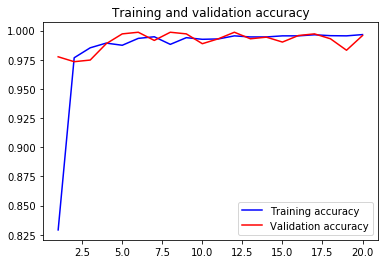

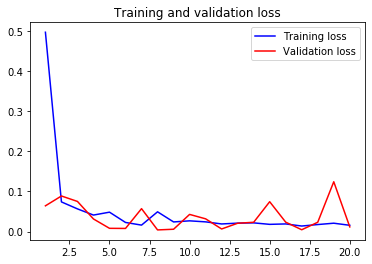

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('Loss.jpg')


In [27]:
import cv2
import tensorflow as tf
CATEGORIES = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
def prepare(file):
    IMG_SIZE = 224
    img_array = cv2.imread(file)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE),3)
    return new_array.reshape(1,IMG_SIZE, IMG_SIZE,-1)
model = tf.keras.models.load_model("../working/model2.h5")
image = prepare("../input/testing/testing/8_3.png") #your image path

# image = image.reshape(image.shape[0],224,224,3)
# print(image.shape)
prediction = model.predict([image])
prediction = list(prediction[0])
print(prediction)
print("And the prediction is:")
result = CATEGORIES[prediction.index(max(prediction))]
print(result)
print("rghv23")

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
And the prediction is:
8
rghv23
